In [1]:
import os
from results import rate_attacked, attacked_by_bins
from core.utils import parse_file, parse_pred_file
from parse import parse
import pickle
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
datasets = [
    {
        'absp': '../__histology',
        'label': 'H-MT',
        'color': 'C1',
        'fmt': 'o-'
    },
    {
        'absp': '../__aorta_razv',
        'label': 'X-AO',
        'color': 'C2',
        'fmt': 's-'
    },
    {
        'absp': '../__xray',
        'label': 'X-TB',
        'color': 'C3',
        'fmt': '^-'
    },
    {
        'absp': '../__histology_tifs_2classes_thyroid',
        'label': 'H-TH',
        'color': 'C4',
        'fmt': 'v-'
    },
    {
        'absp': '../__histology_tifs_2classes_ovary',
        'label': 'H-OV',
        'color': 'C5',
        'fmt': 'v--'
    },
    {
        'absp': '../__histology_tifs_4classes',
        'label': 'H-OV-TH',
        'color': 'C6',
        'fmt': 'D-'
    },
    {
        'absp': '../__xray_age_new_20-35_50-70_',
        'label': 'X-NR2',
        'color': 'C7',
        'fmt': '^--'
    },
    {
        'absp': '../__xray_age_new_17-24_25-41_42-80_',
        'label': 'X-NR3',
        'color': 'C8',
        'fmt': 'o--'
    },
    {
        'absp': '../__ct_lungs',
        'label': 'CT',
        'color': 'C9',
        'fmt': 's--'
    }
]

In [3]:
model_name = 'inceptionv3'

In [4]:
for dataset in datasets[:-1]:
    dataset.update({
        'rate_attacked': np.array(rate_attacked(dataset['absp'], model_name=model_name))
    })
for dataset in datasets:
    dataset.update({
        'labels': np.array(parse_file(os.path.join(dataset['absp'], 'test.txt'))[1]),
        'probs': parse_pred_file(os.path.join(dataset['absp'], model_name, 'pred_test.pkl'))
    })

(20, 10, 30000, 2) float64
(20, 10, 5400, 2) float32
(20, 10, 544, 2) float32
(20, 10, 19072, 2) float32
(20, 10, 19200, 2) float32
(20, 10, 38325, 4) float32
(20, 10, 40000, 2) float32
(20, 10, 110016, 3) float32


In [5]:
cw_probs_f = 'a_test_CW_probs_conf_0_lr_0.01_c_1_max_iter_50.pkl'
cw_l2norms_f = 'a_test_CW_l2norms_conf_0_lr_0.01_c_1_max_iter_50.pkl'
cw_linfnorms_f = 'a_test_CW_linfnorms_conf_0_lr_0.01_c_1_max_iter_50.pkl'
df_probs_f = 'a_test_DF_probs_max_iter_50.pkl'
df_l2norms_f = 'a_test_DF_l2norms_max_iter_50.pkl'
df_linfnorms_f = 'a_test_DF_linfnorms_max_iter_50.pkl'

In [7]:
for dataset in datasets:
    absp = dataset['absp']
    with open(os.path.join(absp, model_name, cw_probs_f), 'rb') as file:
        a_probs = pickle.load(file)
    with open(os.path.join(absp, model_name, cw_l2norms_f), 'rb') as file:
        a_l2norms = pickle.load(file)
    with open(os.path.join(absp, model_name, cw_linfnorms_f), 'rb') as file:
        a_linfnorms = pickle.load(file)
    dataset.update({
        'cw_probs': a_probs,
        'cw_l2norms': a_l2norms,
        'cw_linfnorms': a_linfnorms
    })
    if dataset['label'] in ['X-NR2']:
        with open(os.path.join(absp, model_name, df_probs_f), 'rb') as file:
            a_probs = pickle.load(file)
        with open(os.path.join(absp, model_name, df_l2norms_f), 'rb') as file:
            a_l2norms = pickle.load(file)
        with open(os.path.join(absp, model_name, df_linfnorms_f), 'rb') as file:
            a_linfnorms = pickle.load(file)
        dataset.update({
            'df_probs': a_probs,
            'df_l2norms': a_l2norms,
            'df_linfnorms': a_linfnorms
        })

In [8]:
def get_cw_rate_attacked(dataset, epss):
    cw_probs = dataset['cw_probs']
    cw_linfnorms = dataset['cw_linfnorms']
    labels = dataset['labels']
    total = len(labels)
    cw_labels = np.argmax(cw_probs, axis=1)
    attacked_inds = np.where(cw_labels - labels != 0)[0]
    
    cw_rate_attacked = []
    for eps in epss:
        less_eps_inds = np.where(cw_linfnorms <= eps)[0]
        attacked_less_eps_inds = set(attacked_inds).intersection(set(less_eps_inds))
        cw_rate_attacked.append(len(attacked_less_eps_inds) / total)
    
    return cw_rate_attacked

eps_space = np.arange(0.02, 0.22, 0.02)
for dataset in datasets:
    dataset.update({
        'cw_rate_attacked': get_cw_rate_attacked(dataset, eps_space)
    })

In [9]:
def get_df_rate_attacked(dataset, epss):
    df_probs = dataset['df_probs']
    df_linfnorms = dataset['df_linfnorms']
    labels = dataset['labels']
    total = len(labels)
    df_labels = np.argmax(df_probs, axis=1)
    attacked_inds = np.where(df_labels - labels != 0)[0]
    
    df_rate_attacked = []
    for eps in epss:
        less_eps_inds = np.where(df_linfnorms <= eps)[0]
        attacked_less_eps_inds = set(attacked_inds).intersection(set(less_eps_inds))
        df_rate_attacked.append(len(attacked_less_eps_inds) / total)
    
    return df_rate_attacked

eps_space = np.arange(0.02, 0.22, 0.02)
for dataset in [datasets[-3]]:
    dataset.update({
        'df_rate_attacked': get_df_rate_attacked(dataset, eps_space)
    })

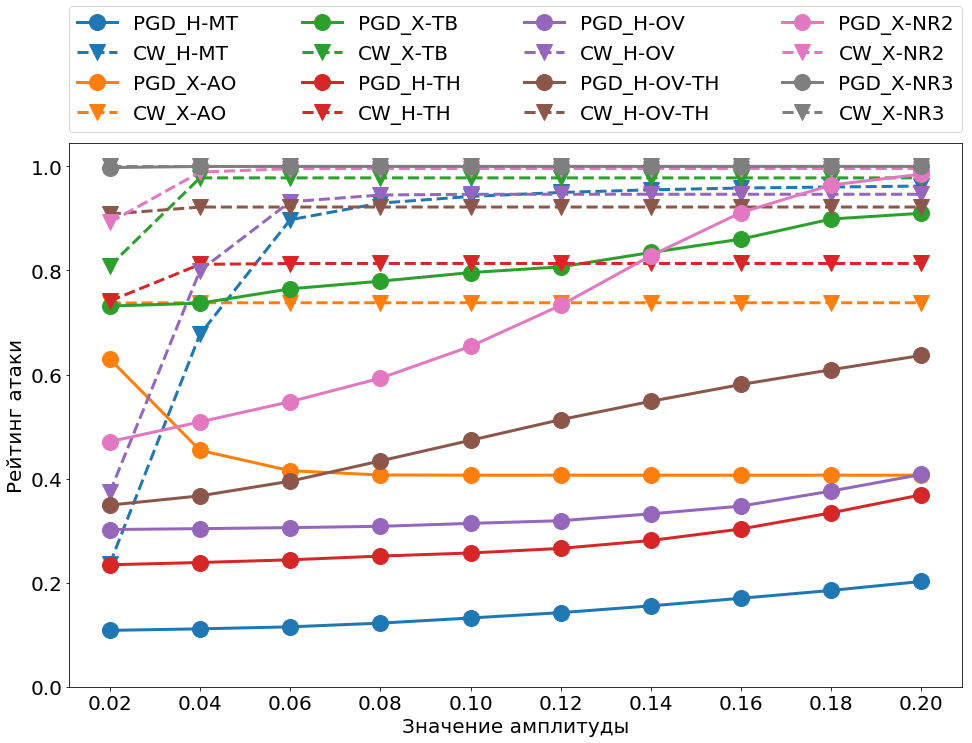

In [82]:
fig = plt.figure(figsize=(16, 10))

x = eps_space
for i, dataset in enumerate(datasets[:-1]):
    y1 = dataset['rate_attacked'][-1][1]
    y2 = dataset['cw_rate_attacked']
    label = dataset['label']
    plt.plot(x, y1, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='PGD_{}'.format(label))
    plt.plot(x, y2, 'v--', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))

plt.xticks(np.arange(0.02, 0.22, 0.02), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
fig.savefig('plots/cw/pgd_cw.png', bbox_inches='tight')

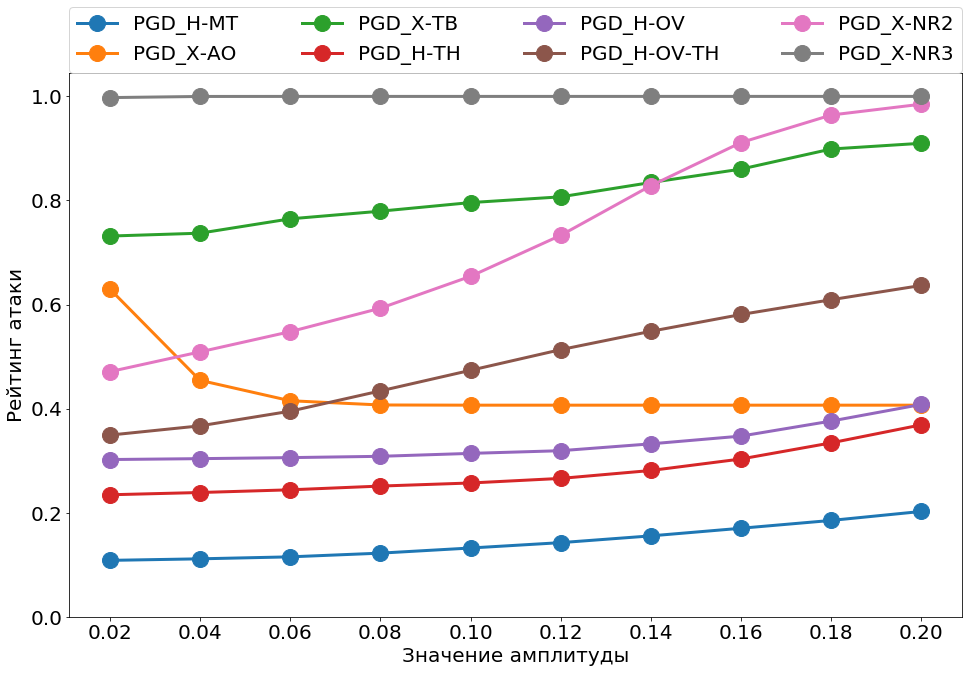

In [83]:
fig = plt.figure(figsize=(16, 10))

x = eps_space
for i, dataset in enumerate(datasets[:-1]):
    y = dataset['rate_attacked'][-1][1]
    y2 = dataset['cw_rate_attacked']
    label = dataset['label']
    plt.plot(x, y, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='PGD_{}'.format(label))

plt.xticks(np.arange(0.02, 0.22, 0.02), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
fig.savefig('plots/cw/pgd.png', bbox_inches='tight')

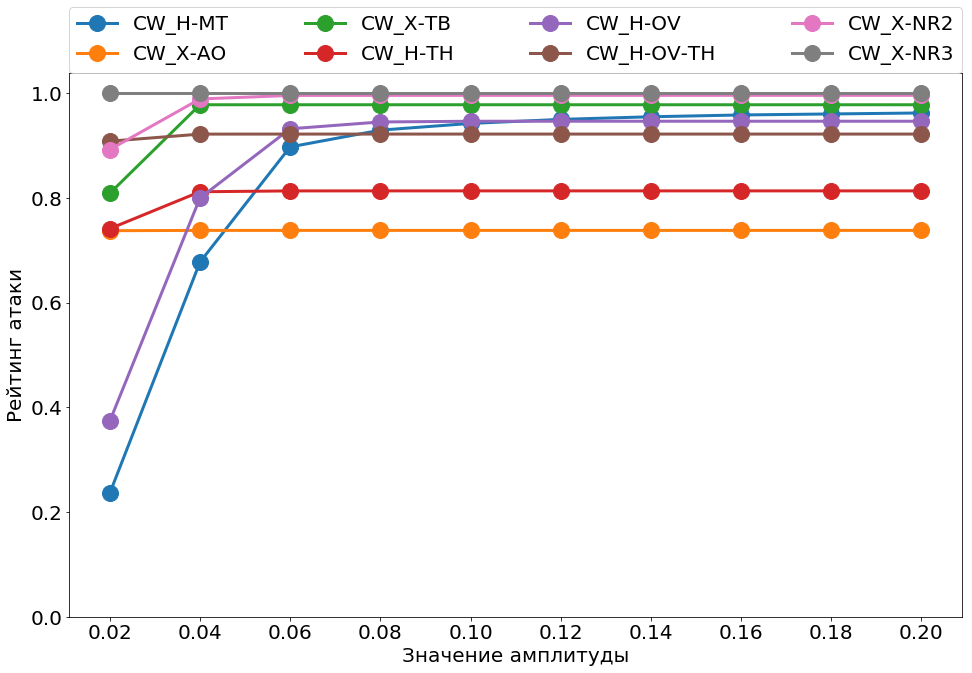

In [84]:
fig = plt.figure(figsize=(16, 10))

x = eps_space
for i, dataset in enumerate(datasets[:-1]):
    y = dataset['cw_rate_attacked']
    label = dataset['label']
    plt.plot(x, y, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))

plt.xticks(np.arange(0.02, 0.22, 0.02), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
fig.savefig('plots/cw/cw.png', bbox_inches='tight')

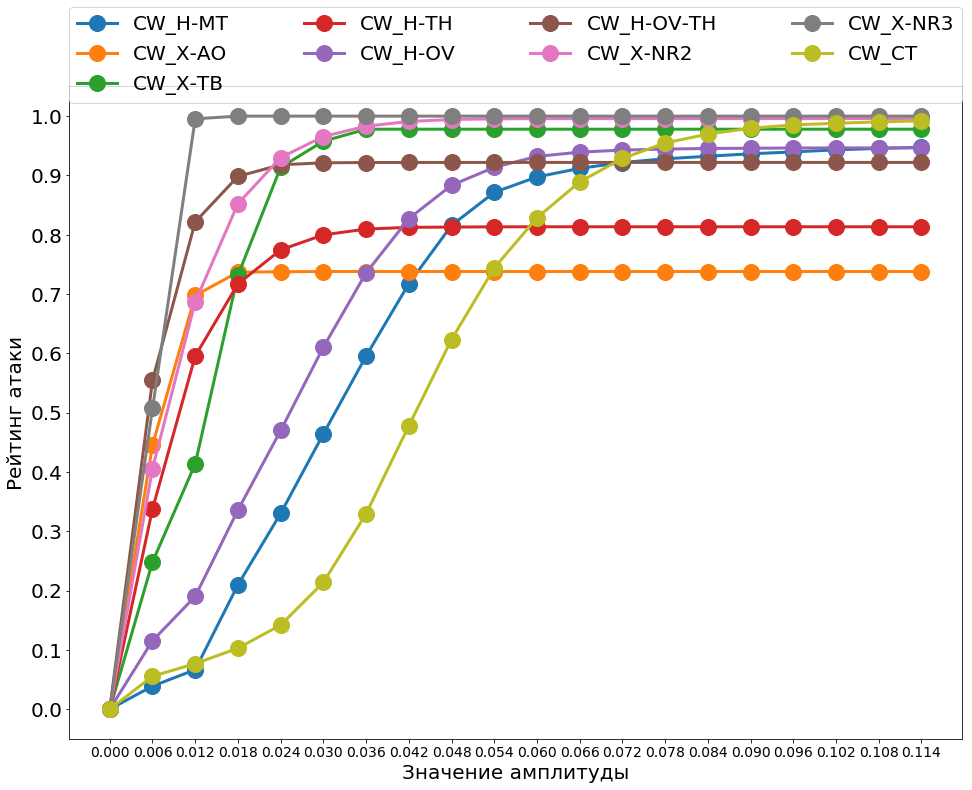

In [85]:
max_eps = max([ds['cw_linfnorms'].max() for ds in datasets])
eps_space_detailed = np.linspace(0, max_eps, 50)
eps_space_detailed = np.arange(0, eps_space_detailed[20], 0.006)[:20]

fig = plt.figure(figsize=(16, 12))

x = eps_space_detailed
for i, dataset in enumerate(datasets):
    y = get_cw_rate_attacked(dataset, eps_space_detailed)
    label = dataset['label']
    plt.plot(x, y, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))

plt.xticks(x, fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
fig.savefig('plots/cw/cw_to_0.114.png', bbox_inches='tight')

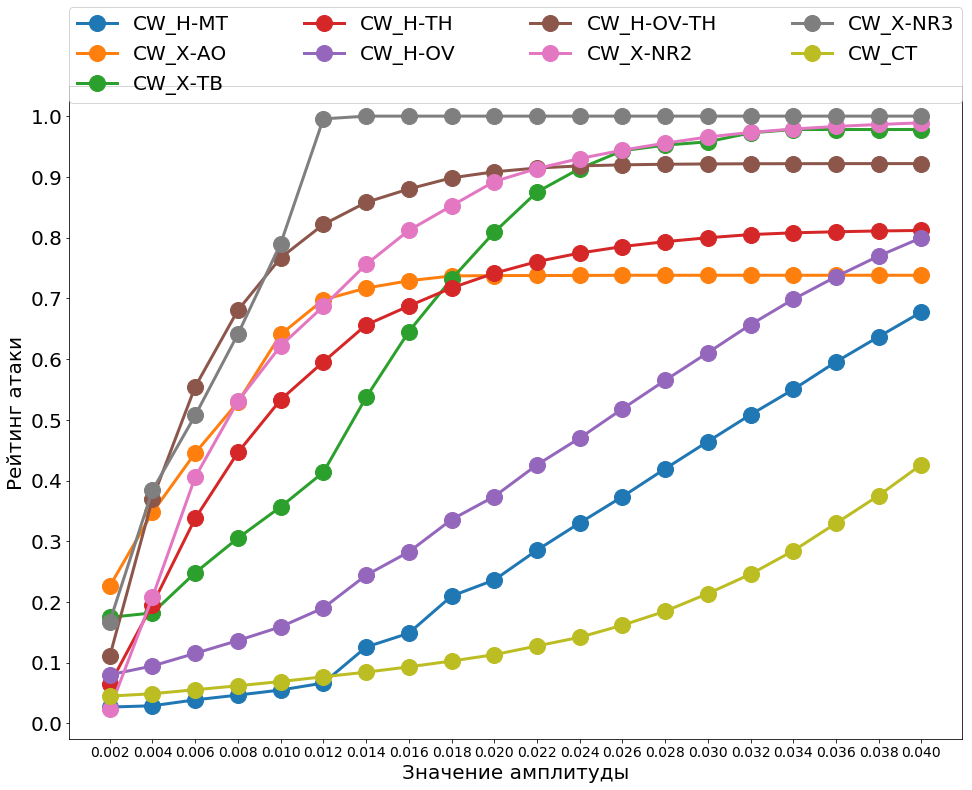

In [87]:
eps_space_detailed = np.linspace(0, 0.04, 21)[1:]

fig = plt.figure(figsize=(16, 12))

x = eps_space_detailed
for i, dataset in enumerate(datasets):
    y = get_cw_rate_attacked(dataset, eps_space_detailed)
    label = dataset['label']
    plt.plot(x, y, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))

plt.xticks(x, fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
fig.savefig('plots/cw/cw_to_0.04.png', bbox_inches='tight')

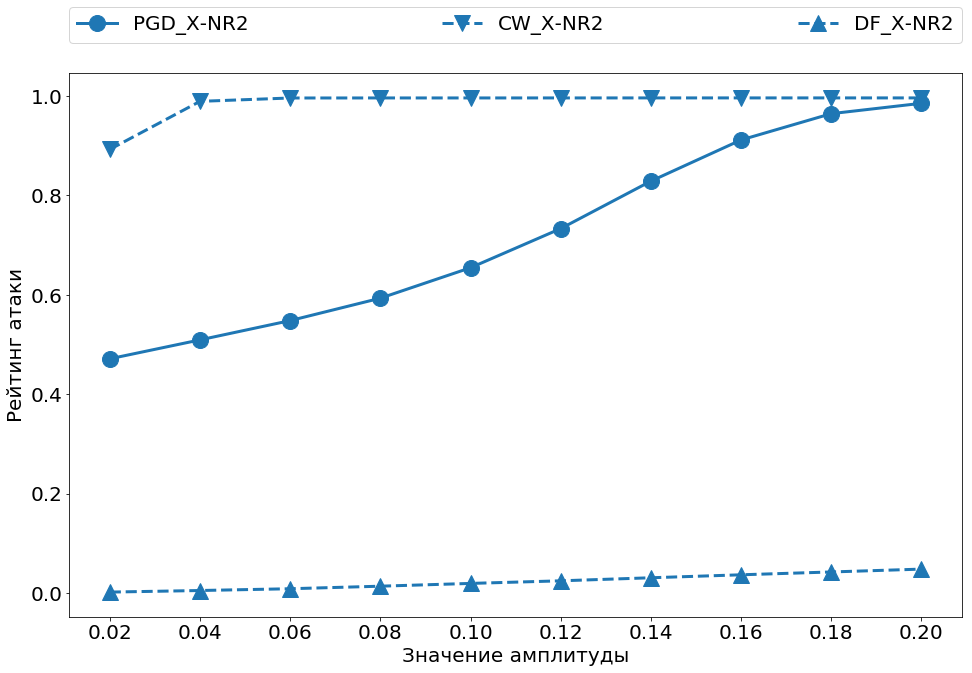

In [11]:
fig = plt.figure(figsize=(16, 10))

x = eps_space
for i, dataset in enumerate([datasets[-3]]):
    y1 = dataset['rate_attacked'][-1][1]
    y2 = dataset['cw_rate_attacked']
    y3 = dataset['df_rate_attacked']
    label = dataset['label']
    plt.plot(x, y1, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='PGD_{}'.format(label))
    plt.plot(x, y2, 'v--', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))
    plt.plot(x, y3, '^--', markersize=16, lw=3, color='C{}'.format(i), label='DF_{}'.format(label))

plt.xticks(np.arange(0.02, 0.22, 0.02), fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
# fig.savefig('plots/cw/pgd_cw.png', bbox_inches='tight')

In [15]:
def get_l2_cw_df_rate_attacked(dataset, epss):
    df_probs = dataset['df_probs']
    df_l2norms = dataset['df_l2norms']
    cw_probs = dataset['cw_probs']
    cw_l2norms = dataset['cw_l2norms']
    labels = dataset['labels']
    total = len(labels)
    df_labels = np.argmax(df_probs, axis=1)
    cw_labels = np.argmax(cw_probs, axis=1)
    attacked_inds = np.where(df_labels - labels != 0)[0]
    
    df_rate_attacked = []
    for eps in epss:
        less_eps_inds = np.where(df_l2norms <= eps)[0]
        attacked_less_eps_inds = set(attacked_inds).intersection(set(less_eps_inds))
        df_rate_attacked.append(len(attacked_less_eps_inds) / total)
        
    attacked_inds = np.where(cw_labels - labels != 0)[0]
    
    cw_rate_attacked = []
    for eps in epss:
        less_eps_inds = np.where(cw_l2norms <= eps)[0]
        attacked_less_eps_inds = set(attacked_inds).intersection(set(less_eps_inds))
        cw_rate_attacked.append(len(attacked_less_eps_inds) / total)
    
    return df_rate_attacked, cw_rate_attacked

l2_max = 0
for ds in [datasets[-3]]:
    if ds['df_l2norms'].max() > l2_max:
        l2_max = ds['df_l2norms'].max()
l2_epss = np.linspace(0, l2_max, 20)
for dataset in [datasets[-3]]:
    dataset.update({
        'df_l2_rate_attacked': get_l2_cw_df_rate_attacked(dataset, epss)[0]
    })

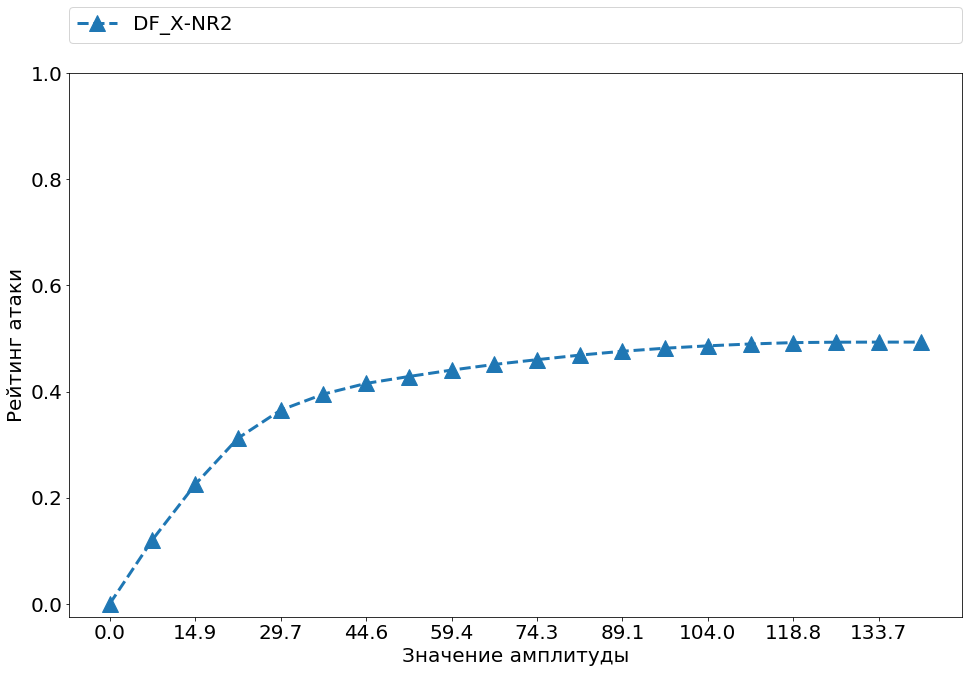

In [22]:
fig = plt.figure(figsize=(16, 10))

x = l2_epss
for i, dataset in enumerate([datasets[-3]]):
#     y1 = dataset['rate_attacked'][-1][1]
#     y2 = dataset['cw_rate_attacked']
    y3 = dataset['df_l2_rate_attacked']
    label = dataset['label']
#     plt.plot(x, y1, 'o-', markersize=16, lw=3, color='C{}'.format(i), label='PGD_{}'.format(label))
#     plt.plot(x, y2, 'v--', markersize=16, lw=3, color='C{}'.format(i), label='CW_{}'.format(label))
    plt.plot(x, y3, '^--', markersize=16, lw=3, color='C{}'.format(i), label='DF_{}'.format(label))

plt.xticks(x[::2], fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=20)
plt.xlabel('Значение амплитуды', fontsize=20)
plt.ylabel('Рейтинг атаки', fontsize=20)
    
plt.legend(fontsize=20, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', borderaxespad=0., ncol=4)
plt.show()
# fig.savefig('plots/cw/pgd_cw.png', bbox_inches='tight')